In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(2)


In [11]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [12]:
#path = "D:/"
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000 
#n_trainSamples = [100,250,500,750,1000,1250,1500]
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [13]:
X_train = load_cls(path+"X_train_tokens.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_tokens.p")

y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def my_preprocessor(doc):
    return doc

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    return doc

custom_vec = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer)
cwm = custom_vec.fit_transform(X_train)
tokens = custom_vec.get_feature_names()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [16]:
feature_pipeline = Pipeline([
('vect',  CountVectorizer(min_df=.0025, max_df=0.25, ngram_range=(1,3),preprocessor=my_preprocessor, tokenizer=my_tokenizer)),
('tfidf', TfidfTransformer()),
])

In [17]:
X_train_f = feature_pipeline.fit_transform(X_train)
X_val_f =feature_pipeline.transform(X_val_cls)

In [18]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'alpha':[0.0001, 0.001, 0.01],
    'l1_ratio':[0.15,0.30],
    'epsilon':[0.1,0.3,0.5],
    'validation_fraction':[0.1,0.2],
    'n_iter_no_change':[5,10]
 }

In [19]:
sgd_clf = GridSearchCV(SGDClassifier(loss='log',fit_intercept=True,n_iter=n_iter, n_jobs=-1), 
                      parameters,n_jobs=-1, cv=5, verbose=4, iid=True)

In [20]:
model = sgd_clf.fit(X_train_f, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 19.6min finished
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [21]:
model.best_score_

0.6347466666666667

In [22]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'epsilon': 0.1, 'alpha': 0.0001, 'n_iter_no_change': 5, 'l1_ratio': 0.15, 'validation_fraction': 0.1}
alpha: 0.0001
epsilon: 0.1
l1_ratio: 0.15
n_iter_no_change: 5
validation_fraction: 0.1


In [23]:
pickle.dump(model,open("SGDClassifier_tokens_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [24]:
X_test = load_cls(path+"X_test_tokens.p")
y_test = load_cls(path+"y_test.p")

In [25]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = SGDClassifier(loss='log',alpha=model.best_params_['alpha'],l1_ratio=model.best_params_['l1_ratio'], 
                              epsilon=model.best_params_['epsilon'],validation_fraction = model.best_params_['validation_fraction'],
                              n_iter_no_change=model.best_params_['n_iter_no_change'],
                                   fit_intercept=True, n_iter=n_iter, n_jobs=-1)

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = feature_pipeline.transform(X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = feature_pipeline.transform(X_test)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:0.57 sec
Validation Accuracy: 50.00%
Validation Time:2.19 sec
Test Accuracy: 49.99%
Test Time:2.18 sec
(0.43212380952380924, 0.19266666666666668, 0.5353333333333333)
MRR: 0.43212380952380924
MRR Time:0.57 sec
SampleSize: 500


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:0.82 sec
Validation Accuracy: 50.00%
Validation Time:2.25 sec
Test Accuracy: 50.14%
Test Time:2.24 sec
(0.4404777777777791, 0.19466666666666665, 0.5613333333333334)
MRR: 0.4404777777777791
MRR Time:0.56 sec
SampleSize: 1000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:1.06 sec
Validation Accuracy: 50.26%
Validation Time:2.33 sec
Test Accuracy: 50.29%
Test Time:2.31 sec
(0.45157777777777874, 0.21533333333333332, 0.5606666666666666)
MRR: 0.45157777777777874
MRR Time:0.57 sec
SampleSize: 10000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:8.41 sec
Validation Accuracy: 56.29%
Validation Time:2.41 sec
Test Accuracy: 55.78%
Test Time:2.39 sec
(0.5075444444444466, 0.2806666666666667, 0.632)
MRR: 0.5075444444444466
MRR Time:0.57 sec
SampleSize: 20000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:17.58 sec
Validation Accuracy: 58.29%
Validation Time:2.40 sec
Test Accuracy: 57.64%
Test Time:2.36 sec
(0.5122333333333352, 0.27666666666666667, 0.6686666666666666)
MRR: 0.5122333333333352
MRR Time:0.57 sec
SampleSize: 50000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:45.43 sec
Validation Accuracy: 59.47%
Validation Time:2.42 sec
Test Accuracy: 58.99%
Test Time:2.41 sec
(0.5223793650793664, 0.2826666666666667, 0.6813333333333333)
MRR: 0.5223793650793664
MRR Time:0.78 sec
SampleSize: 75000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:68.68 sec
Validation Accuracy: 60.69%
Validation Time:2.38 sec
Test Accuracy: 59.39%
Test Time:2.37 sec
(0.5208333333333353, 0.2793333333333333, 0.6833333333333333)
MRR: 0.5208333333333353
MRR Time:0.72 sec
[0.5, 0.5, 0.5026, 0.5629, 0.5829, 0.5947, 0.6069]
[0.4999, 0.5014, 0.5029, 0.5578, 0.5764, 0.5899, 0.5939]
[0.43212380952380924, 0.4404777777777791, 0.45157777777777874, 0.5075444444444466, 0.5122333333333352, 0.5223793650793664, 0.5208333333333353]
[0.19266666666666668, 0.19466666666666665, 0.21533333333333332, 0.2806666666666667, 0.27666666666666667, 0.2826666666666667, 0.2793333333333333]
[0.5353333333333333, 0.5613333333333334, 0.5606666666666666, 0.632, 0.6686666666666666, 0.6813333333333333, 0.6833333333333333]


In [28]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SGDClassifier_Accuracy_tokens.png")
    #plt.show()

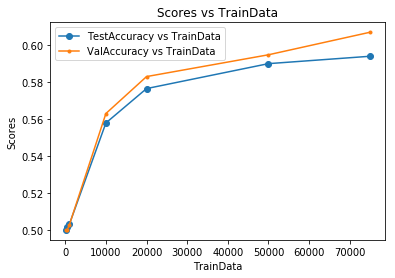

In [29]:
accuracyVisualization()

In [30]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SGDClassifier_Mrr_tokens.png")
    plt.show()

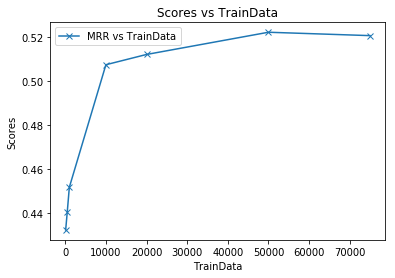

In [31]:
mrrVisualization()

In [32]:
#Precision @1 and Precision @2 Visualizations
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precision Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SGD_Precision_tokens.png")
    plt.show()

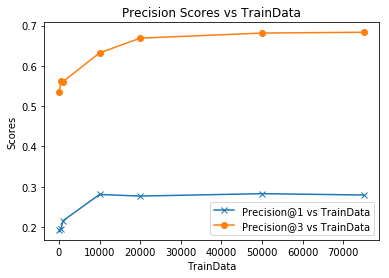

In [33]:
precisionVisualization()